# Import Packages

In [27]:
paltas_directory = '/Users/hollowayp/paltas/'
import os
os.chdir(paltas_directory)
import paltas
from paltas.Analysis.AnalysisConfigs.train_config_examp import learning_params,batch_size,flip_pairs,n_epochs,random_seed,norm_images,loss_function,model_type,directory_to_save
from paltas.Analysis import hierarchical_inference,dataset_generation, loss_functions, conv_models
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import pandas as pd
import numpy as np
import corner
import emcee
import numba
import os

np.random.seed(4)


/Example_C


# Generate Images

In [3]:
folder = directory_to_save
!python3 ./paltas/generate.py ./paltas/Configs/Examples/config_simple.py ./$directory_to_save/training --n 100 --tf_record --h5
!python3 ./paltas/generate.py ./paltas/Configs/Examples/config_simple.py ./$directory_to_save/validation --n 100 --tf_record --h5


2023-08-05 19:47:04.346526: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
Save folder path: .//Example_C/training
100%|█████████████████████████████████████████| 100/100 [04:07<00:00,  2.48s/it]
Dataset generation complete. Acceptance rate: 1.000
Saving 100 files into the tf record
100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 52.57i

# Train Model

In [17]:
!python3 ./paltas/Analysis/train_model.py ./paltas/Analysis/AnalysisConfigs/train_config_examp.py --h5

2023-08-05 20:13:08.874747: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
N_VAL_NPY 100
Checking for training data.
TFRecord found at ./Example_C/training/data.tfrecord
Checking for validation data.
TFRecord found at ./Example_C/validation/data.tfrecord
Checking for normalization csv
Using input normalization found at ./Example_C/trainingnorms.csv
RAW <TFRe

# Generate and Save Model Predictions

## Configuration

In [19]:
model_weights = paltas_directory+'/Example_C/model_weights/02-14.33.h5'

EPOCH = n_epochs#200
img_size = (128,128,1)
#random_seed = 2
#batch_size = 5
#flip_pairs = None
NORM_IMAGES = norm_images#False
LOG_NORM_IMAGES = False
#learning_params = ['main_deflector_parameters_theta_E',
#                    'main_deflector_parameters_gamma1','main_deflector_parameters_gamma2',
#                    'main_deflector_parameters_gamma','main_deflector_parameters_e1',
#                    'main_deflector_parameters_center_y',
#                    'main_deflector_parameters_e2','main_deflector_parameters_center_x',
#                    'subhalo_parameters_sigma_sub']
learning_params_print = learning_params
log_learning_params = []
num_params = len(learning_params+log_learning_params)
loss_type = loss_function#'full'
#model_type = 'xresnet34'

tf.random.set_seed(random_seed)

if loss_type == 'full':
    num_outputs = num_params + int(num_params*(num_params+1)/2)
    loss_func = loss_functions.FullCovarianceLoss(num_params)

elif loss_type == 'diag':
    num_outputs = 2*num_params
    loss_func = loss_functions.DiagonalCovarianceLoss(num_params)

if model_type == 'xresnet101':
    model = conv_models.build_xresnet101(img_size,num_outputs)
if model_type == 'xresnet34':
    model = conv_models.build_xresnet34(img_size,num_outputs)
model.load_weights(model_weights)
#model.load_weights(model_weights,by_name=True,skip_mismatch=True)


## def gen_network_predictions

In [21]:
##############################
# generate network predictions
##############################
def gen_network_predictions(test_folder,norm_path,learning_params,loss_type,
                            loss_func,model,samples=False,shuffle=True,
                            norm_images=True,log_norm_images=False):
    """
    Generate neural network predictions given a paltas generated folder of images

    Args:
        test_folder (string): Path to folder of paltas generated images, 
            containig a data.tfrecord file
        norm_path (string): Path to .csv containing normalization of parameters
            applied during training of network
        learning_params (list(string)): Names of parameters learned
        loss_type (string): 'full' or 'diag' currently supported
        loss_func (paltas.Analysis.loss_function): Loss function object, (needs
            draw_samples() and convert_output() functionality)
        model (paltas.Analysis.conv_models): Trained neural network with weights
            loaded
        samples (bool, default=False): If True, samples from the NPE are returned
        shuffle (bool, default=True): If True, the order of the test set is shuffled
            when generating predictions
        norm_images (bool, default=True): If True, normalize test set images
        log_norm_images (bool, default=False): If True, test set imags are
            log-normalized and rescaled to range (0,1)

    Returns:
        If samples=True:
            y_test, y_pred, std_pred, prec_pred, predict_samps
        Else:
            y_test, y_pred, std_pred, prec_pred
    """

    npy_folder_test = test_folder
    tfr_test_path = os.path.join(npy_folder_test,'data.tfrecord')
    input_norm_path = norm_path
    log_learning_params = []

    if loss_type not in {'full','diag'}:
        raise ValueError('loss_type not supported')

    tf_dataset_test = dataset_generation.generate_tf_dataset(tfr_test_path,learning_params,
        3,1,norm_images=norm_images,
        kwargs_detector=None,input_norm_path=input_norm_path,
        log_learning_params=log_learning_params,shuffle=shuffle)

    n_rotations = int(2)

    y_test_list = []
    y_pred_list = []
    std_pred_list = []
    cov_pred_list = []
    predict_samps_list = []

    for batch in tf_dataset_test:
        images = batch[0].numpy()
        y_test = batch[1].numpy()

        y_pred_rot_list = []
        for rot_angle in (np.random.uniform(size=n_rotations)*2*np.pi):
            image_rot = dataset_generation.rotate_image_batch(images,[],None,rot_angle)
            output = model.predict(image_rot)
            if loss_type == 'full':
                y_pred_rot,_,_ = loss_func.convert_output(output=output)
            else:
                y_pred_rot,_ = loss_func.convert_output(output)

            y_pred_rot = y_pred_rot.numpy()
            y_pred_rot_list.append(y_pred_rot)

        y_pred = np.mean(y_pred_rot_list,axis=0)
        
        # use unrotated output for covariance matrix
        output = model.predict(images)

        if loss_type == 'full':
            y_pred_no_rot, precision_matrix, _ = loss_func.convert_output(output)
        else:
            y_pred_no_rot, log_var_pred = loss_func.convert_output(output)
        
        # x & y need to be from the un-rotated predictions
        y_pred[:,6:8] = y_pred_no_rot[:,6:8]
        # TODO: fix this
        y_pred = y_pred_no_rot

        # compute std. dev.
        if loss_type == 'full':
            cov_mat = np.linalg.inv(precision_matrix.numpy())
            std_pred = np.zeros((cov_mat.shape[0],cov_mat.shape[1]))
            for i in range(len(std_pred)):
                std_pred[i] = np.sqrt(np.diag(cov_mat[i]))
            
        else:
            std_pred = np.exp(log_var_pred/2)
            cov_mat = np.empty((len(std_pred),len(std_pred[0]),len(std_pred[0])))
            for i in range(len(std_pred)):
                cov_mat[i] = np.diag(std_pred[i]**2)

        y_test_list.append(y_test)
        y_pred_list.append(y_pred)
        std_pred_list.append(std_pred)
        cov_pred_list.append(cov_mat)
        if samples:
            un_samples = loss_func.draw_samples(output,n_samps=10000)
            # trying to unnormalize samples correctly 
            # unnormalize_outputs() expects shape (batchsize,num_params)
            for j in range(0,un_samples.shape[1]):
                dataset_generation.unnormalize_outputs(input_norm_path,
                    learning_params+log_learning_params,
                    un_samples[:,j,:])
            predict_samps_list.append(un_samples)

    y_test = np.concatenate(y_test_list)
    y_pred = np.concatenate(y_pred_list)
    std_pred = np.concatenate(std_pred_list)
    cov_pred = np.concatenate(cov_pred_list)
    if samples:
        predict_samps = np.concatenate(predict_samps_list,axis=1)

    if input_norm_path is not None:
        dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_pred,standard_dev=std_pred,cov_mat=cov_pred)
        dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_test)
                                      
    prec_pred = np.linalg.inv(cov_pred)

    if samples:
        return y_test, y_pred, std_pred, prec_pred, predict_samps
    
    return y_test, y_pred, std_pred, prec_pred


def gen_doppel_predictions(test_folder,doppel_names,norm_path,learning_params,
                           loss_type,loss_func,model,samples=False,
                           norm_images=True,log_norm_images=False):
    
    """
    Generate neural network predictions given a folder of individual paltas folders
    (specifically useful for doppelganger format)

    Args:
        test_folder (string): Path to folder of folders, where each folder is for an 
            individual paltas generated images, containig a data.tfrecord file
        doppel_names (list[string]): Names of the sub-folders
        norm_path (string): Path to .csv containing normalization of parameters
            applied during training of network
        learning_params (list(string)): Names of parameters learned
        loss_type (string): 'full' or 'diag' currently supported
        loss_func (paltas.Analysis.loss_function): Loss function object, (needs
            draw_samples() and convert_output() functionality)
        model (paltas.Analysis.conv_models): Trained neural network with weights
            loaded
        samples (bool, default=False): If True, samples from the NPE are returned
        norm_images (bool, default=True): If True, normalize test set images
        log_norm_images (bool, default=False): If True, test set imags are
            log-normalized and rescaled to range (0,1)

    Returns:
        If samples=True:
            y_test, y_pred, std_pred, prec_pred, predict_samps
        Else:
            y_test, y_pred, std_pred, prec_pred
    """
    
    log_learning_params = []
    if loss_type not in {'full','diag'}:
        raise ValueError('loss_type not supported')

    y_test_doppel = []
    y_pred_doppel = []
    std_pred_doppel = []
    cov_pred_doppel = []
    predict_samps_doppel = []


    for i,doppel in enumerate(doppel_names):
        npy_folder_test = test_folder+doppel+'/'
        tfr_test_path = os.path.join(npy_folder_test,'data.tfrecord')
        input_norm_path = norm_path

        tf_dataset_test = dataset_generation.generate_tf_dataset(tfr_test_path,
            learning_params,3,1,norm_images=norm_images,
            log_norm_images=log_norm_images,kwargs_detector=None,
            input_norm_path=input_norm_path,
            log_learning_params=log_learning_params)

        # only one thing in tf_dataset_test since individual doppelgangers
        for t in tf_dataset_test:
            batch = t
        images = batch[0].numpy()
        y_test_d = batch[1].numpy()

        # use unrotated output for covariance matrix
        output = model.predict(images)

        if loss_type == 'full':
            y_pred_no_rot, precision_matrix, _ = loss_func.convert_output(output)
        else:
            y_pred_no_rot, log_var_pred = loss_func.convert_output(output)

        y_pred_d = y_pred_no_rot

        # compute std. dev.
        if loss_type == 'full':
            cov_mat = np.linalg.inv(precision_matrix.numpy())
            std_pred_d = np.zeros((cov_mat.shape[0],cov_mat.shape[1]))
            for i in range(len(std_pred_d)):
                std_pred_d[i] = np.sqrt(np.diag(cov_mat[i]))
            
        else:
            std_pred_d = np.exp(log_var_pred/2)
            cov_mat = np.empty((len(std_pred_d),len(std_pred_d[0]),len(std_pred_d[0])))
            for i in range(len(std_pred_d)):
                cov_mat[i] = np.diag(std_pred_d[i]**2)

        y_test_doppel.append(y_test_d)
        y_pred_doppel.append(y_pred_d)
        std_pred_doppel.append(std_pred_d)
        cov_pred_doppel.append(cov_mat)
        if samples:
            un_samples = loss_func.draw_samples(output,n_samps=10000)
            # trying to unnormalize samples correctly 
            # unnormalize_outputs() expects shape (batchsize,num_params)
            for j in range(0,un_samples.shape[1]):
                dataset_generation.unnormalize_outputs(input_norm_path,
                    learning_params+log_learning_params,
                    un_samples[:,j,:])
            predict_samps_doppel.append(un_samples)


    y_test_doppel = np.concatenate(y_test_doppel)
    y_pred_doppel = np.concatenate(y_pred_doppel)
    std_pred_doppel = np.concatenate(std_pred_doppel)
    cov_pred_doppel = np.concatenate(cov_pred_doppel)
    if samples:
        predict_samps_doppel = np.concatenate(predict_samps_doppel,axis=1)

    dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_pred_doppel,standard_dev=std_pred_doppel,
                                        cov_mat=cov_pred_doppel)
    dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_test_doppel)

    # get back to prec matrix
    # np.linalg.inv expects matrix dimensions as last 2 dimensions (11,8,8)
    prec_pred_doppel = np.linalg.inv(cov_pred_doppel)

    if samples:
        return y_test_doppel, y_pred_doppel, std_pred_doppel, prec_pred_doppel, predict_samps_doppel
    
    return y_test_doppel, y_pred_doppel, std_pred_doppel, prec_pred_doppel 


##########################
# Original 12 parameter HI
##########################
def original_HI(n_lenses,y_pred,prec_pred,train_mean,train_scatter):
    """
    Returns:
        sampler object
    """
    # Let's define a few of the parameters for our inference
    n_emcee_samps = int(1e4)

    # Load the predictions for the mean and covariance for our model. We'll have to do a little reshaping here since the code
    # expect an array of mean values and a precision matrix.
    y_pred_hi = np.ascontiguousarray(y_pred[:n_lenses,:6]).reshape((n_lenses,6)).astype(np.float64)
    prec_pred_hi = np.ascontiguousarray(prec_pred[:n_lenses,:6,:6]).reshape((n_lenses,6,6)).astype(np.float64)

    # The interim training distribution.
    mu_omega_i = np.array(train_mean)
    cov_omega_i =np.diag(np.array(train_scatter)**2)

    # uniform prior with bounds
    @numba.njit()
    def eval_func_omega(hyperparameters):
        # theta_E
        if np.abs(1-hyperparameters[0]) > 0.4998:
            return -np.inf
        # gamma1/gamma2
        if np.abs(hyperparameters[1]) > 0.4 or np.abs(hyperparameters[2]) > 0.4:
            return -np.inf
        # gamma_lens
        if hyperparameters[3] < 1 or hyperparameters[3] > 3:
            return -np.inf
        # e1/e2
        if np.abs(hyperparameters[4]) > 0.6 or np.abs(hyperparameters[5]) > 0.6:
            return -np.inf
        
        # Need to set bounds to avoid random singular matrix proposals

        # restricting sigma_gamma_lens to be strictly narrower than training prior
        if hyperparameters[9] > np.log(0.3):
            return -np.inf
        
        for h in hyperparameters[6:]:
            # penalize too narrow
            if h < -6.9:
                return -np.inf
            # penalize too wide
            if h > 0.69:
                return -np.inf
            
        # log prior for uniform in sigma space, as opposed to uniform in log space
        return np.sum(hyperparameters[6:])

    # Initialize our class and then give it the network predictions. These are set to global variables in case you want to use
    # pooling.
    prob_class = hierarchical_inference.ProbabilityClassAnalytical(mu_omega_i,cov_omega_i,eval_func_omega)
    prob_class.set_predictions(mu_pred_array_input=y_pred_hi,prec_pred_array_input=prec_pred_hi)

    # Set a few of the parameters we will need to pass to emcee
    n_walkers = 40
    ndim = 12

    # Generate an initial state informed by prior range
    cur_state_mu = np.concatenate((np.random.uniform(low=0.8,high=1.2,size=(n_walkers,1)),
        np.random.uniform(low=-0.1,high=0.1,size=(n_walkers,1)),
        np.random.uniform(low=-0.1,high=0.1,size=(n_walkers,1)),
        np.random.uniform(low=1.85,high=2.15,size=(n_walkers,1)),
        np.random.uniform(low=-0.1,high=0.1,size=(n_walkers,1)),
        np.random.uniform(low=-0.1,high=0.1,size=(n_walkers,1))),axis=1)
    cur_state_sigmas = np.log(np.concatenate((np.random.uniform(low=0.01,high=0.3,size=(n_walkers,1)),
        np.random.uniform(low=0.01,high=0.16,size=(n_walkers,1)),
        np.random.uniform(low=0.01,high=0.16,size=(n_walkers,1)),
        np.random.uniform(low=0.01,high=0.1,size=(n_walkers,1)),
        np.random.uniform(low=0.01,high=0.24,size=(n_walkers,1)),
        np.random.uniform(low=0.01,high=0.24,size=(n_walkers,1))),axis=1))
    cur_state = np.concatenate((cur_state_mu,cur_state_sigmas),axis=1)

    sampler = emcee.EnsembleSampler(n_walkers, ndim,prob_class.log_post_omega)
    _ = sampler.run_mcmc(cur_state,n_emcee_samps,progress=True,skip_initial_state_check=True)

    return sampler

#####################
# Fixed 6 Param HI
#####################
def fixed_param_HI(log_likelihood,n_emcee_samps=1e4):

    # sampling params
    n_walkers = 40
    ndim = 6
    n_emcee_samps = int(n_emcee_samps)

    def log_prior(hyperparameters):
        # hyperparameters come in order: 
        # (mu_theta_E, mu_gamma_lens, sigma_theta_E, sigma_gamma1, sigma_gamma_lens, sigma_e1)
        if np.abs(1-hyperparameters[0]) > 0.4998:
            return -np.inf
        # gamma_lens
        if hyperparameters[1] < 1 or hyperparameters[1] > 3:
            return -np.inf
        
        # Need to set bounds to avoid random singular matrix proposals

        # restricting sigma_gamma_lens to be strictly narrower than training prior
        if hyperparameters[4] > 0.2:
            return -np.inf
        
        # restrict all other sigmas to be strictly narrower than training prior
        # sigma_thetaE
        if hyperparameters[2] > 0.2:
            return -np.inf
        # sigma_gamma_1,2
        if hyperparameters[3] > 0.16:
            return -np.inf
        # sigma_e_1,2
        if hyperparameters[5] > 0.24:
            return -np.inf
        
        # penalize too narrow
        for h in hyperparameters[2:]:
            if h < 0.001:
                return -np.inf
            
        # uniform prior
        return 0

    def log_posterior(hyperparameters):

        lp = log_prior(hyperparameters)
        
        if np.isfinite(lp):
            lp += log_likelihood(hyperparameters)

        return lp
    
    cur_state_mu = np.concatenate((np.random.uniform(low=0.9,high=1.05,size=(n_walkers,1)),
    np.random.uniform(low=1.95,high=2.05,size=(n_walkers,1))),axis=1)
    cur_state_sigmas = np.concatenate((np.random.uniform(low=0.01,high=0.3,size=(n_walkers,1)),
    np.random.uniform(low=0.01,high=0.16,size=(n_walkers,1)),
    np.random.uniform(low=0.01,high=0.1,size=(n_walkers,1)),
    np.random.uniform(low=0.01,high=0.24,size=(n_walkers,1))),axis=1)
    cur_state = np.concatenate((cur_state_mu,cur_state_sigmas),axis=1)

    sampler3 = emcee.EnsembleSampler(n_walkers, ndim,log_posterior)
    sampler3.run_mcmc(cur_state,n_emcee_samps,progress=True,skip_initial_state_check=True)

    return sampler3

def fixed_param_analytical_HI(n_lenses,y_pred,prec_pred,train_mean,train_scatter,n_emcee_samps=1e4):

    # network predictions to feed in
    y_pred_hi = np.ascontiguousarray(y_pred[:n_lenses,:6]).reshape((n_lenses,6)).astype(np.float64)
    prec_pred_hi = np.ascontiguousarray(prec_pred[:n_lenses,:6,:6]).reshape((n_lenses,6,6)).astype(np.float64)

    # The interim training distribution.
    mu_omega_i = np.array(train_mean)
    cov_omega_i =np.diag(np.array(train_scatter)**2)
    prec_omega_i = np.linalg.inv(cov_omega_i)

    def log_likelihood(hyperparameters):
        
        mus_omega = np.asarray([hyperparameters[0],0.,0.,hyperparameters[1],0.,0.])
        sigmas = np.asarray([hyperparameters[2],hyperparameters[3],hyperparameters[3],
                             hyperparameters[4],hyperparameters[5],hyperparameters[5]])
        # this inverse could be a possible issue
        prec_omega = np.linalg.inv(np.diag(sigmas**2))
        result = 0
        for p in range(0,np.shape(y_pred_hi)[0]):
            result += gaussian_product_analytical(y_pred_hi[p,:],prec_pred_hi[p,:,:],
                mu_omega_i,prec_omega_i,mus_omega,prec_omega)
            
        return result
    
    return fixed_param_HI(log_likelihood,n_emcee_samps)
    


def fixed_param_sampling_HI(n_lenses,y_pred,prec_pred,val_metadata_path,n_emcee_samps=1e4):
    # doesn't require a functional form for the training prior, just a histogram of values
    # one of the args should just be the path to the validation metadata.csv (is 5,000 samples enough?)
    
    # num samples used for importance sampling
    N_IS = 5000
    # get samples from p(xi_k|Omega_int,d_k)
    cov_pred = np.linalg.inv(prec_pred)
    # NPE samples in shape (5000,11,6)
    from scipy.stats import multivariate_normal
    NPE_samples = np.empty((5000,n_lenses,6))
    for j in range(0,n_lenses):
        NPE_samples[:,j,:] = multivariate_normal(mean=y_pred[j,:6],
                                          cov=cov_pred[j,:6,:6]).rvs(size=(N_IS,6))

    # need p(xi_k|Omega_int) for each NPE sample
    from scipy.stats import rv_histogram
    # retrieve distribution of lens parameters from validation set metadata
    val_df = pd.read_csv(val_metadata_path)
    params_of_interest = ['main_deflector_parameters_theta_E',
                          'main_deflector_parameters_gamma1','main_deflector_parameters_gamma2',
                          'main_deflector_parameters_gamma',
                          'main_deflector_parameters_e1','main_deflector_parameters_e2']
    NPE_interim_probs = np.empty((5000,n_lenses,6))
    for i,p in enumerate(params_of_interest):
        hist = np.histogram(val_df[p].to_numpy())
        NPE_interim_probs[:,:,i] = rv_histogram(hist).pdf(NPE_samples[:,:,i])

    def log_likelihood(hyperparameters):


        # compute p(xi_k|Omega) for NPE samples given hyperparameters from above
        loc_sampled = np.asarray([hyperparameters[0],0.,0.,hyperparameters[1],0.,0.])
        cov_sampled = np.diag(np.asarray([hyperparameters[2],hyperparameters[3],hyperparameters[3],
            hyperparameters[4],hyperparameters[5],hyperparameters[5]])**2)
        NPE_omega_probs = multivariate_normal(loc=loc_sampled,cov=cov_sampled).pdf(NPE_samples)

        # make sure we don't overflow when coming out of log space for this calculation
        #with jax.experimental.enable_x64():

        # compute importance sampling sum/product (rip log space)
        imp_sampling_sum = np.sum(NPE_omega_probs/NPE_interim_probs,axis=0)
        # log(product) = sum(logs)
        imp_sampling_log_factor = np.sum(np.log(imp_sampling_sum))

        return imp_sampling_log_factor

    return fixed_param_HI(log_likelihood,n_emcee_samps)

def individ_corner_plots(sampler,true_hyperparameters,param_labels,n_lenses,burnin=int(1e3)):

    num_params = sampler.chain.shape[2]
    chain = sampler.chain[:,burnin:,:].reshape((-1,num_params))
    fontsize = 18
    color='#FFAA00'
    truth_color = 'grey'
    hist_kwargs = {'density':True,'color':color,'lw':3}
    
    for j in range(0,int(num_params/2)):
        # show just gamma_lens 
        figure = corner.corner(chain[:,[j,j+int(num_params/2)]],labels=np.asarray(param_labels)[[j,j+int(num_params/2)]],
                bins=20,show_titles=False,plot_datapoints=False,label_kwargs=dict(fontsize=fontsize),
                levels=[0.68,0.95],color=color,fill_contours=True,hist_kwargs=hist_kwargs,title_fmt='.2f',
                max_n_ticks=3,fig=None,truths=true_hyperparameters[[j,j+int(num_params/2)]],
                truth_color=truth_color,range=np.ones(2)*0.98)

        axes = np.array(figure.axes).reshape((2, 2))
        custom_lines = [Line2D([0], [0], color=color, lw=4),
            Line2D([0], [0], color=truth_color, lw=4)]

        """"
        # set some custom axes limits
        if j == 3:
            mu_lim = [1.9,2.06]
            sigma_lim = [0.001,0.1]
            axes[0,0].set_xlim(mu_lim)
            axes[1,0].set_xlim(mu_lim)
            axes[1,0].set_ylim(sigma_lim)
            axes[1,1].set_xlim(sigma_lim)
        """

        axes[0,1].legend(custom_lines,['Samples','Truth'],frameon=False,fontsize=12)

        plt.suptitle('%d Lenses'%(n_lenses),fontsize=15)
        plt.show()


def doppel_individ_corner_plots(sampler,param_labels,n_lenses,burnin=int(1e3)):

    num_params = sampler.chain.shape[2]
    chain = sampler.chain[:,burnin:,:].reshape((-1,num_params))
    fontsize = 18
    color='#FFAA00'
    hist_kwargs = {'density':True,'color':color,'lw':3}
    
    for j in range(0,int(num_params/2)):
        # show just gamma_lens 
        figure = corner.corner(chain[:,[j,j+int(num_params/2)]],labels=np.asarray(param_labels)[[j,j+int(num_params/2)]],
                bins=20,show_titles=False,plot_datapoints=False,label_kwargs=dict(fontsize=fontsize),
                levels=[0.68,0.95],color=color,fill_contours=True,hist_kwargs=hist_kwargs,title_fmt='.2f',
                max_n_ticks=3,fig=None,range=np.ones(2)*0.98)

        #axes = np.array(figure.axes).reshape((2, 2))
        #custom_lines = [Line2D([0], [0], color=color, lw=4),
        #    Line2D([0], [0], color=truth_color, lw=4)]

        """"
        # set some custom axes limits
        if j == 3:
            mu_lim = [1.9,2.06]
            sigma_lim = [0.001,0.1]
            axes[0,0].set_xlim(mu_lim)
            axes[1,0].set_xlim(mu_lim)
            axes[1,0].set_ylim(sigma_lim)
            axes[1,1].set_xlim(sigma_lim)
        """

        #axes[0,1].legend(custom_lines,['Samples','Truth'],frameon=False,fontsize=12)

        plt.suptitle('%d Doppelganger Lenses'%(n_lenses),fontsize=15)
        plt.show()

########################
# gamma lens corner plot
########################

def gamma_lens_corner(sampler,true_params,gl_idx,n_lenses,burnin=int(1e3)): 

    num_params = sampler.chain.shape[2]
    chain = sampler.chain[:,burnin:,:].reshape((-1,num_params))

    corner_param_print=[r'$\gamma_{\mathrm{lens},\mu}$',
                        r'$\gamma_{\mathrm{lens},\sigma}$']
    fontsize = 18
    color='#FFAA00'
    truth_color = 'grey'
    hist_kwargs = {'density':True,'color':color,'lw':3}

    figure = corner.corner(chain[:,gl_idx],labels=np.asarray(corner_param_print),
        bins=20,show_titles=False,plot_datapoints=False,label_kwargs=dict(fontsize=fontsize),
        levels=[0.68,0.95],color=color,fill_contours=True,hist_kwargs=hist_kwargs,title_fmt='.2f',
        max_n_ticks=3,fig=None,truths=true_params,
        truth_color=truth_color,range=np.ones(2)*0.98)

    axes = np.array(figure.axes).reshape((2, 2))
    custom_lines = [Line2D([0], [0], color=color, lw=4),
        Line2D([0], [0], color=truth_color, lw=4)]

    # set some custom axes limits
    mu_lim = [1.9,2.06]
    sigma_lim = [0.001,0.1]
    axes[0,0].set_xlim(mu_lim)
    axes[1,0].set_xlim(mu_lim)
    axes[1,0].set_ylim(sigma_lim)
    axes[1,1].set_xlim(sigma_lim)

    axes[0,1].legend(custom_lines,['Samples','Truth'],frameon=False,fontsize=12)

    plt.suptitle('$\gamma_{lens}$, %d lenses'%(n_lenses),fontsize=15)
    plt.show()

def overlay_contours(samplers_list,colors_list,true_params_list,iofi,
    param_labels,sampler_labels,save_path=None,bounds=None):
    """
    Args:
        samplers_list (list): list of emcee sampler objects
        colors_list (list): list of colors for each contour
        true_params_list (list): list of [float], ground truth ONLY for iofi
        iofi (list[int]): list of indices of parameters to be plotted
        param_labels (list[string]): list of labels for each parameter of interest
        sampler_labels (list[string]): list of labels for each sampler/contour
        bounds (list): list of [min,max] bounds for each param's contour
    """
    import copy

    corner_kwargs = {
        'labels':np.asarray(param_labels),
        'bins':20,
        'show_titles':False,
        'plot_datapoints':False,
        'label_kwargs':dict(fontsize=25),
        'levels':[0.68,0.95],
        'color':colors_list[0],
        'fill_contours':True,
        'contourf_kwargs':{},
        'hist_kwargs':{'density':True,'color':colors_list[0],
                       'lw':3},
        'title_fmt':'.2f',
        'plot_density':False,
        'max_n_ticks':3,
        'truths':np.zeros(len(iofi)),
        'truth_color':'grey',
        'range':np.ones(len(iofi))*0.98,
    }

    for i,s in enumerate(samplers_list):
        if i == 0:
            corner_kwargs_copy = copy.deepcopy(corner_kwargs)
            figure = param_of_interest_corner(s,iofi,corner_kwargs_copy,true_params_list[i])
        else:
            corner_kwargs_copy = copy.deepcopy(corner_kwargs)
            corner_kwargs_copy['color'] = colors_list[i]
            corner_kwargs_copy['hist_kwargs']['color'] = colors_list[i] 
            figure = param_of_interest_corner(s,iofi,corner_kwargs_copy,true_params_list[i],
                                              figure=figure)

    num_params = len(iofi)
    axes = np.array(figure.axes).reshape((num_params, num_params))
    custom_lines = []
    for color in colors_list:
        custom_lines.append(Line2D([0], [0], color=color, lw=4))
    axes[0,num_params-1].legend(custom_lines,sampler_labels,
        frameon=False,fontsize=20)
    
    # apply custom bounds to the contours
    if bounds is not None:
        for r in range(0,num_params):
            for c in range(0,r+1):
                if r == c and r == 0:
                    print('0,0')
                axes[r,c].set_xlim(bounds[c])
                if r != c :
                    axes[r,c].set_ylim(bounds[r])
    
    if save_path:
        plt.savefig(save_path)

    return figure



def overlay_shot_noise_contours(samplers_list,iofi,param_labels,true_params):

    transparent_color = COLORS['hyperparam_narrow'] + '4D'

    corner_kwargs = {
        'labels':np.asarray(param_labels),
        'bins':20,
        'show_titles':False,
        'plot_datapoints':False,
        'label_kwargs':dict(fontsize=25),
        'levels':[0.68,0.95],
        'color':transparent_color,
        'fill_contours':True,
        'contourf_kwargs':{},
        'hist_kwargs':{'density':True,'color':COLORS['hyperparam_narrow'],
                       'lw':3,'alpha':0.3},
        'title_fmt':'.2f',
        'plot_density':False,
        'max_n_ticks':3,
        'truths':np.zeros(len(iofi)),
        'truth_color':'grey',
        'range':np.ones(len(iofi))*0.98,
    }

    for i,s in enumerate(samplers_list):
        if i == 0:
            figure = param_of_interest_corner(s,iofi,corner_kwargs,true_params)
        else:
            figure = param_of_interest_corner(s,iofi,corner_kwargs,true_params,
                                              figure=figure)

    return figure

def param_of_interest_corner(sampler,iofi,corner_kwargs,true_params,
                             burnin=int(1e3),bounds=None,title=None,
                             figure=None,display_metric=False):
    """
    Args: 
        sampler: emcee sampler object containing the chain
        iofi ([int]): list of indices of which params to plot
        corner_kwargs (dict): corner.corner() arguments
        true_params (list[float]): list of ground truth ONLY for iofi
    Returns:
        matplotlib figure object
    """
    num_params = sampler.chain.shape[2]
    chain = sampler.chain[:,burnin:,:].reshape((-1,num_params))
    # subtract off the ground truth for params of interest
    for j,i in enumerate(iofi):
        chain[:,i] -= true_params[j]

    if figure is None:
        figure = corner.corner(chain[:,iofi],fig=None,**corner_kwargs)
    else:
        figure = corner.corner(chain[:,iofi],fig=figure,**corner_kwargs)

    num_params = len(iofi)
    axes = np.array(figure.axes).reshape((num_params, num_params))
    custom_lines = [Line2D([0], [0], color=COLORS['hyperparam_narrow'], lw=4),
        Line2D([0], [0], color='grey', lw=4)]

    axes[0,num_params-1].legend(custom_lines,['Narrow','Truth'],frameon=False,fontsize=12)

    if title is not None:
        plt.suptitle(title,fontsize=20)


    if bounds is not None:

        for r in range(0,num_params):
            for c in range(0,r+1):
                axes[r,c].set_xlim(bounds[c])
                if r != c :
                    axes[r,c].set_ylim(bounds[r])
                else:
                    if display_metric:
                        c_idx = iofi[c]
                        med = np.median(chain[:,c_idx])
                        low = np.quantile(chain[:,c_idx],q=0.1586)
                        high = np.quantile(chain[:,c_idx],q=0.8413)
                        axes[r,c].legend(custom_lines,
                            ['%.2f $\pm^{%.2f}_{%.2f}$'%(med,high-med,med-low),'%.2f'%(true_params[c])],
                            frameon=True,fontsize=12,handlelength=1,loc='lower right')

    #plt.show()

    return figure

##############################
# corner plot for all params
##############################
def full_corner_plot(sampler,true_hyperparameters,param_labels,title,bounds=None,burnin=int(1e3),
                     label_fontsize=18,title_fontsize=18):
    fontsize = label_fontsize
    color='#FFAA00'
    truth_color = 'grey'
    hist_kwargs = {'density':True,'color':color,'lw':3}

    chain3 = sampler.chain[:,burnin:,:].reshape((-1,6))

    figure = corner.corner(chain3,labels=np.asarray(param_labels),bins=20,
                show_titles=False,plot_datapoints=False,label_kwargs=dict(fontsize=fontsize),
                levels=[0.68,0.95],color=color,fill_contours=True,
                hist_kwargs=hist_kwargs,title_fmt='.2f',max_n_ticks=3,fig=None,
                truths=true_hyperparameters,
                truth_color=truth_color,range=np.ones(6)*0.98)

    axes = np.array(figure.axes).reshape((6, 6))
    custom_lines = [Line2D([0], [0], color=color, lw=4),
            Line2D([0], [0], color=truth_color, lw=4)]
    #axes[0,5].legend(custom_lines,['Samples','Truth'],frameon=False,fontsize=15)

    # set some custom axes limits if bounds is not None
    custom_lines = [Line2D([0], [0], color=color, lw=2),
            Line2D([0], [0], color=truth_color, lw=2)]
    if bounds is not None:

        for r in range(0,6):
            for c in range(0,r+1):
                if r == c and r == 0:
                    print('0,0')
                axes[r,c].set_xlim(bounds[c])
                if r != c :
                    axes[r,c].set_ylim(bounds[r])
                else:
                    med = np.median(chain3[:,c])
                    low = np.quantile(chain3[:,c],q=0.1586)
                    high = np.quantile(chain3[:,c],q=0.8413)
                    axes[r,c].legend(custom_lines,
                        ['%.2f $\pm^{%.2f}_{%.2f}$'%(med,high-med,med-low),'%.2f'%(true_hyperparameters[c])],
                        frameon=True,fontsize=12,handlelength=1,loc='lower right')
                    axes[r,c].set_title(param_labels[c])
                    """
                    axes[r,c].text(0.8,0.9,'%.2f $\pm^{%.2f}_{%.2f}$'%(med,high,low),
                                   horizontalalignment='center',
                                   verticalalignment='center',
                                   transform=axes[r,c].transAxes,fontsize=10,color=color)
                    axes[r,c].text(0.5,0.9,'%.2f'%(true_hyperparameters[c]),
                                   horizontalalignment='center',
                                   verticalalignment='center',
                                   transform=axes[r,c].transAxes,fontsize=10,color=truth_color)
                    """
                    

    plt.suptitle(title,fontsize=title_fontsize)
    plt.show()

def doppel_corner_plot(sampler,param_labels,title,bounds=None,burnin=int(1e3)):
    fontsize = 18
    color='#FFAA00'
    hist_kwargs = {'density':True,'color':color,'lw':3}

    chain3 = sampler.chain[:,burnin:,:].reshape((-1,6))

    figure = corner.corner(chain3,labels=np.asarray(param_labels),bins=20,
                show_titles=False,plot_datapoints=False,label_kwargs=dict(fontsize=fontsize),
                levels=[0.68,0.95],color=color,fill_contours=True,
                hist_kwargs=hist_kwargs,title_fmt='.2f',max_n_ticks=3,fig=None,range=np.ones(6)*0.98)

    axes = np.array(figure.axes).reshape((6, 6))
    custom_lines = [Line2D([0], [0], color=color, lw=4)]
    axes[0,5].legend(custom_lines,['Samples'],frameon=False,fontsize=15)

    # set some custom axes limits if bounds is not None
    custom_lines = [Line2D([0], [0], color=color, lw=2)]

    if bounds is not None:
        for r in range(0,6):
            for c in range(0,r+1):
                if r == c and r == 0:
                    print('0,0')
                axes[r,c].set_xlim(bounds[c])
                if r != c :
                    axes[r,c].set_ylim(bounds[r])
                else:
                    med = np.median(chain3[:,c])
                    low = np.quantile(chain3[:,c],q=0.1586)
                    high = np.quantile(chain3[:,c],q=0.8413)
                    axes[r,c].legend(custom_lines,
                        ['%.2f $\pm^{%.2f}_{%.2f}$'%(med,high-med,med-low)],
                        frameon=True,fontsize=9,handlelength=1,loc='lower right')
                    axes[r,c].set_title(param_labels[c])
                    """
                    axes[r,c].text(0.8,0.9,'%.2f $\pm^{%.2f}_{%.2f}$'%(med,high,low),
                                   horizontalalignment='center',
                                   verticalalignment='center',
                                   transform=axes[r,c].transAxes,fontsize=10,color=color)
                    axes[r,c].text(0.5,0.9,'%.2f'%(true_hyperparameters[c]),
                                   horizontalalignment='center',
                                   verticalalignment='center',
                                   transform=axes[r,c].transAxes,fontsize=10,color=truth_color)
                    """

    for r in range(0,6):
        for c in range(0,r+1):
            if r==c:
                med = np.median(chain3[:,c])
                low = np.quantile(chain3[:,c],q=0.1586)
                high = np.quantile(chain3[:,c],q=0.8413)
                axes[r,c].legend(custom_lines,
                    ['%.2f $\pm^{%.2f}_{%.2f}$'%(med,high-med,med-low)],
                    frameon=True,fontsize=12,handlelength=1,loc='lower right')
                axes[r,c].set_title(param_labels[c])

                    

    plt.suptitle(title,fontsize=20)
    plt.show()

def apply_corner_bounds(bounds,figure):

    axes = np.array(figure.axes).reshape((len(bounds), len(bounds)))
    for r in range(0,len(bounds)):
        for c in range(0,r+1):
            axes[r,c].set_xlim(bounds[c])
            if r != c :
                axes[r,c].set_ylim(bounds[r])

#################################
# analyze chains from original HI
#################################
def original_analyze_chains(sampler,param_labels,true_hyperparameters,
                            outfile,effective_samples=False,show_chains=False,
                            burnin=int(1e3)):

    if show_chains:
        for i in range(sampler.chain.shape[2]):
            plt.figure()
            plt.plot(sampler.chain[:,:,i].T,'.')
            plt.title(param_labels[i])
            plt.show()

    if effective_samples:
        print("Effective Samples Per Parameter:")
        print(cr.effective_samples(sampler.chain[:,burnin:,:], maxlag=5000))
        print("")

    num_params = sampler.chain.shape[2]
    chain = sampler.chain[:,burnin:,:].reshape((-1,num_params))

    labels = ['Ground Truth', 'Inferred Value', 'Bias in $\sigma$', 'Fractional Error']

    med = np.median(chain,axis=0)
    low = np.quantile(chain,q=0.1586,axis=0)
    high = np.quantile(chain,q=0.8413,axis=0)

    error = med - true_hyperparameters
    sigma = ((high-med)+(med-low))/2
    bias = error/sigma

    metrics = [true_hyperparameters,med,bias,error]

    with open(outfile,'w') as f:

        f.write('\hline')
        f.write('\n')

        for i,lab in enumerate(labels):
            f.write(lab)
            f.write(' ')

            for k,m in enumerate(metrics[i]):
                f.write('& ')
                f.write(str(np.around(m,2)))
                f.write(' ')
                if i == 1:
                    f.write('$\pm$' + str(np.around(sigma[k],2)))

            f.write(r'\\')
            f.write('\n')
            f.write('\hline')
            f.write('\n')


    for j in range(num_params):

        med = np.median(chain[:,j])
        low = np.quantile(chain[:,j],q=0.1586)
        high = np.quantile(chain[:,j],q=0.8413)
        print(param_labels[j])
        print("\t", round(med,3), "+", round(high-med,3), "-", round(med-low,3))
        error = med - true_hyperparameters[j]
        if error > 0:
            bias = error/round(med-low,3)
        else:
            bias = error/round(high-med,3)
        print("\t", "Bias in Std. Devs: ", round(bias,3))

        frac_error = error/true_hyperparameters[j]
        print("\t","Fractional Error: ",round(frac_error,3))

############################
# Fractional error on params
############################
def fractional_error_chain(sampler,true_hyperparameters,burnin=int(1e3)):
    """Compute fractional error on hyperparameters given a sampler object from 
    MCMC

    Args:
        sampler (emcee.EnsembleSampler): sampler object after running MCMC
        true_hyperparameters (list[float]): ground truth for hyperparameters
        burnin (int,default=1e3): How many samples to remove from the front
            of the MCMC chain
    Returns:
        list(float)
    """

    num_params = sampler.chain.shape[2]
    chain = sampler.chain[:,burnin:,:].reshape((-1,num_params))

    med = np.median(chain,axis=0)
    error = med - true_hyperparameters
    frac_error = error/true_hyperparameters

    return frac_error



#############################
# Re-Weighted Lens Posteriors
#############################

def reweighted_lens_posteriors(y_pred,prec_pred,train_mean,train_scatter,debug=False):
    """
    Assumes using fixed_param_HI
    """
    n_lenses = np.shape(y_pred)[0]
    n_params = np.shape(y_pred)[1]
    # TODO: need to check assumptions ab inversing
    cov_pred = np.linalg.inv(prec_pred)

    # prepare interim training sampler
    mu_omega_i = np.array(train_mean)
    cov_omega_i =np.diag(np.array(train_scatter)**2)
    interim_prior_prob = multivariate_normal(mean=mu_omega_i,cov=cov_omega_i)

    iofi = np.arange(0,n_lenses)
    samples_list = []
    weights_list = []
    for i in range(0,n_lenses):
        # index every lens but current lens
        iofi = np.concatenate((np.arange(0,i),np.arange(i+1,n_lenses)))
        # specify Num samples & burn-in
        sampler = fixed_param_HI(n_lenses-1,y_pred[iofi,:],prec_pred[iofi,:,:],
                                 train_mean,train_scatter,n_emcee_samps=1e4)
        burnin = int(1e3)
        chain_HI = sampler.chain[:,burnin:,:].reshape((-1,n_params))
        # generate samples from multivariate Gaussian NPE
        NPE_multivariate_sampler = multivariate_normal(mean=y_pred[i,:],cov=cov_pred[i,:,:])
        NPE_samples = NPE_multivariate_sampler.rvs(size=int(1e4))
        # calculate weights using chain from sampler
        weights = np.empty(np.shape(NPE_samples)[0])
        # loop through xi_k samples & calculate a weight for each one
        for k in range(0,np.shape(NPE_samples)[0]):
            # TODO: check that array dimensions are in order: batch_size, num_params
            xi_k = NPE_samples[k,:]
            sum = 0
            # loop through samples from p(Omega|{d}!=k) & construct sum
            for j in range(0,np.shape(chain_HI)[0]):
                hyperparameters = chain_HI[j,:]
                mus = np.asarray([hyperparameters[0],0.,0.,hyperparameters[1],0.,0.])
                sigmas = np.asarray([hyperparameters[2],hyperparameters[3],hyperparameters[3],
                             hyperparameters[4],hyperparameters[5],hyperparameters[5]])
                cov = np.diag(sigmas**2)
                numerator = multivariate_normal.pdf(xi_k,mean=mus,cov=cov)
                denominator = interim_prior_prob.pdf(xi_k)
                sum += numerator/denominator

            weights[k] = NPE_multivariate_sampler.pdf(xi_k) * sum / np.shape(chain_HI)[0] 

        samples_list.append(NPE_samples)
        weights_list.append(weights)

        # only evaluate once if de-bugging
        if debug:
            break

    # return samples & weights for each lens posterior
    return samples_list, weights_list



def reweighted_lens_posteriors_faster(y_pred,prec_pred,train_mean,train_scatter,debug=False,
                                      reweight_indices=None,check_chains=False):
    """
    Assumes using fixed_param_HI
    """
    n_lenses = np.shape(y_pred)[0]
    n_params = np.shape(y_pred)[1]
    # TODO: need to check assumptions ab inversing
    cov_pred = np.linalg.inv(prec_pred)

    iofi = np.arange(0,n_lenses)
    samples_list = []
    weights_list = []
    
    if reweight_indices is None:
        reweight_indices = np.arange(0,np.shape(y_pred)[0])
    for i in reweight_indices:
        # index every lens but current lens
        iofi = np.concatenate((np.arange(0,i),np.arange(i+1,n_lenses)))
        # specify Num samples & burn-in
        sampler = fixed_param_analytical_HI(n_lenses-1,y_pred[iofi,:],prec_pred[iofi,:,:],
                                 train_mean,train_scatter,n_emcee_samps=1e4)
        # save plot of chain if requested
        if check_chains:
            plt.figure()
            plt.plot(sampler.chain[:,:,1].T,'.')
            plt.title('$\gamma_{lens},\mu$')
            plt.savefig('HI_RW_chain_%d.png'%(i))
        burnin = int(1e3)
        chain_HI = sampler.chain[:,burnin:,:].reshape((-1,n_params))
        # generate samples from multivariate Gaussian NPE
        NPE_multivariate_sampler = multivariate_normal(mean=y_pred[i,:],cov=cov_pred[i,:,:])
        NPE_samples = NPE_multivariate_sampler.rvs(size=int(5e3))
        # calculate weights using chain from sampler
        weights = np.empty(np.shape(NPE_samples)[0])
        # loop through xi_k samples & calculate a weight for each one
        for k in range(0,np.shape(NPE_samples)[0]):
            # TODO: check that array dimensions are in order: batch_size, num_params
            xi_k = NPE_samples[k,:]

            # chain_HI has shape: [num_samps,num_params]
            mus = np.vstack((chain_HI[:,0],np.zeros(np.shape(chain_HI[:,0])),
                            np.zeros(np.shape(chain_HI[:,0])),chain_HI[:,1],
                            np.zeros(np.shape(chain_HI[:,0])),np.zeros(np.shape(chain_HI[:,0])))).T
            sigmas = np.vstack((chain_HI[:,2],chain_HI[:,3],chain_HI[:,3],
                                chain_HI[:,4],chain_HI[:,5],chain_HI[:,5])).T
            
            # dot product: (xi_k - mu)**2 dot (1/sigmas)**2 over num_params dimension
            # ((xi_k - mus)/sigmas)**2 should have dimension [num_samps,num_params]
            exponent = -0.5*(np.sum(((xi_k - mus)/sigmas)**2,axis=1))
            # exponent should now have dimension num_samps
            # sqrt(det(sigmas**2)) = prod(sigmas)
            to_sum = (1/(np.product(sigmas,axis=1)))*np.exp(exponent)
            sum = np.sum(to_sum)

            # divide out interim prior piece
            interim_exponent = 0.5*np.sum(((xi_k - train_mean)/train_scatter)**2)
            to_multiply = np.prod(train_scatter)*np.exp(interim_exponent)

            weights[k] = NPE_multivariate_sampler.pdf(xi_k) * sum * to_multiply / np.shape(chain_HI)[0] 

        samples_list.append(NPE_samples)
        weights_list.append(weights)

        # only evaluate once if de-bugging
        if debug:
            break

    # return samples & weights for each lens posterior
    return samples_list, weights_list


def reweighted_table(samples_list,weights_list,y_truth,file_name):

    # get y_pred and std_pred from chains
    y_pred = np.empty((len(samples_list),samples_list[0].shape[1]))
    std_pred = np.empty((len(samples_list),samples_list[0].shape[1]))
    for i in range(len(samples_list)):
        samps = samples_list[i]
        weights = weights_list[i]
        weights = weights.reshape(len(weights),1)
        mus = np.sum(samps*weights,axis=0)/np.sum(weights,axis=0)
        stds = np.sqrt(np.sum(weights*(samps - mus)**2,axis=0)/np.sum(weights,axis=0))
        y_pred[i,:] = mus
        std_pred[i,:] = stds

    visualization_utils.table_metrics(y_pred,y_truth,std_pred,file_name)

    return y_pred,std_pred

## Save Network Predictions

In [22]:
#y_test, y_pred, std_pred, prec_pred
network_predictions = gen_network_predictions(test_folder=paltas_directory+'/paltas/example',norm_path=None,\
                        learning_params=learning_params,\
                        loss_type=loss_function,
                        loss_func=loss_func,\
                        model=model,samples=False,shuffle=True,
                        norm_images=norm_images,log_norm_images=False)

def save_network_predictions(network_predictions,filename):
    np.save(filename+'_test',network_predictions[0])
    np.save(filename+'_pred',network_predictions[1])
    np.save(filename+'_std_pred',network_predictions[2])
    np.save(filename+'_prec_pred',network_predictions[3])

save_network_predictions(network_predictions,paltas_directory+'/paltas/example_predictions/example')

RAW <TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)> RAW PATH /Users/hollowayp/paltas//paltas/example/data.tfrecord


/Users/hollowayp/paltas/paltas/Analysis/dataset_generation.py:278: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


DATASET <_RepeatDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(9,), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 53ms/step


# Load Model Outputs

In [23]:
# Define the true population mean and its scatter
true_mean = np.array(pd.read_csv(paltas_directory+'/paltas/example/norms.csv')['mean']) #NB: In practice, this should be the true population mean not the 
#training mean - these may differ if the training is not a representative population (e.g. chosen to be gaussian).
true_scatter = np.array(pd.read_csv(paltas_directory+'/paltas/example/norms.csv')['std']) #NB: ^^ Ditto

# Assume some consistent, large noise for all of our lens images
#image_information_scatter = np.random.uniform(low=4e-3,high=6e-3,size=100)
#image_mean = true_mean + np.random.normal(size=100)*image_information_scatter + np.random.normal(size=100)*true_scatter

# This in the mean and scatter of the information in each image, but remember our network predicts a posterior which means we need to multiply our likelihood
# by the training prior
train_mean = np.array(pd.read_csv(paltas_directory+'/paltas/example/norms.csv')['mean']) 
train_scatter = np.array(pd.read_csv(paltas_directory+'/paltas/example/norms.csv')['std']) 
#network_means = (image_mean * train_scatter**2 + train_mean*image_information_scatter**2)/(train_scatter**2 + image_information_scatter**2)
#network_scatter = np.sqrt((train_scatter**2 * image_information_scatter**2)/(train_scatter**2 + image_information_scatter**2))
network_means = np.load(paltas_directory+'/paltas/example_predictions/example_pred.npy').astype('float64')
network_scatter = np.load(paltas_directory+'/paltas/example_predictions/example_std_pred.npy').astype('float64')
network_prec = np.load(paltas_directory+'/paltas/example_predictions/example_prec_pred.npy').astype('float64')

# Let's define a few of the parameters for our inference
n_lenses = 100
n_emcee_samps = int(1e3)
burnin = int(1e2)
chains_folder = './notebook_data/'
backend_path = '/example_chains.h5'
chains_path = os.path.join(chains_folder,backend_path)

# Load the predictions for the mean and covariance for our model. We'll have to do a little reshaping here since the code
# expect an array of mean values and a precision matrix.
y_pred = network_means[:n_lenses].reshape((n_lenses,9))
prec_pred = 1/np.square(network_scatter[:n_lenses].reshape((n_lenses,9)))


# Hierarchical Inference

In [24]:
#From https://github.com/smericks/deep-lens-modeling/blob/9ff7f79715f0dd47bb24b2e1d279c2fe78b792dd/mcmc_utils.py#L285
def original_HI(n_lenses,y_pred,prec_pred,train_mean,train_scatter):
    """
    Returns:
        sampler object
    """
    # Let's define a few of the parameters for our inference
    n_emcee_samps = int(1e3)

    # Load the predictions for the mean and covariance for our model. We'll have to do a little reshaping here since the code
    # expect an array of mean values and a precision matrix.
    y_pred_hi = np.ascontiguousarray(y_pred[:n_lenses,:9]).reshape((n_lenses,9)).astype(np.float64)
    prec_pred_hi = np.ascontiguousarray(prec_pred[:n_lenses,:9,:9]).reshape((n_lenses,9,9)).astype(np.float64)

    # The interim training distribution.
    mu_omega_i = np.array(train_mean)
    cov_omega_i =np.diag(np.array(train_scatter)**2)

    # uniform prior with bounds
    @numba.njit()
    def eval_func_omega(hyperparameters):
        # theta_E
        if np.abs(1-hyperparameters[0]) > 0.4998:
            return -np.inf
        # gamma1/gamma2
        if np.abs(hyperparameters[1]) > 0.4 or np.abs(hyperparameters[2]) > 0.4:
            return -np.inf
        # gamma_lens
        if hyperparameters[3] < 1 or hyperparameters[3] > 3:
            return -np.inf
        # e1/e2
        if np.abs(hyperparameters[4]) > 0.6 or np.abs(hyperparameters[5]) > 0.6:
            return -np.inf
        
        # Need to set bounds to avoid random singular matrix proposals

        # restricting sigma_gamma_lens to be strictly narrower than training prior
        if hyperparameters[9] > np.log(0.3):
            return -np.inf
        
        for h in hyperparameters[6:]:
            # penalize too narrow
            if h < -6.9:
                return -np.inf
            # penalize too wide
            if h > 0.69:
                return -np.inf
            
        # log prior for uniform in sigma space, as opposed to uniform in log space
        return np.sum(hyperparameters[6:])

    # Initialize our class and then give it the network predictions. These are set to global variables in case you want to use
    # pooling.
    prob_class = hierarchical_inference.ProbabilityClassAnalytical(mu_omega_i,cov_omega_i,eval_func_omega)
    prob_class.set_predictions(mu_pred_array_input=y_pred_hi,prec_pred_array_input=prec_pred_hi)

    # Set a few of the parameters we will need to pass to emcee
    n_walkers = 40
    ndim = 18

    # Generate an initial state informed by prior range
    cur_state_mu = np.concatenate((np.random.uniform(low=0.8,high=1.2,size=(n_walkers,1)),
        np.random.uniform(low=-0.1,high=0.1,size=(n_walkers,1)),
        np.random.uniform(low=-0.1,high=0.1,size=(n_walkers,1)),
        np.random.uniform(low=1.85,high=2.15,size=(n_walkers,1)),
        np.random.uniform(low=-0.1,high=0.1,size=(n_walkers,1)),
        np.random.uniform(low=-0.1,high=0.1,size=(n_walkers,1)),\
        np.random.uniform(low=-0.1,high=0.1,size=(n_walkers,1)),\
        np.random.uniform(low=-0.1,high=0.1,size=(n_walkers,1)),\
        np.random.uniform(low=-0.1,high=0.1,size=(n_walkers,1))),axis=1)
    cur_state_sigmas = np.log(np.concatenate((np.random.uniform(low=0.01,high=0.3,size=(n_walkers,1)),
        np.random.uniform(low=0.01,high=0.16,size=(n_walkers,1)),
        np.random.uniform(low=0.01,high=0.16,size=(n_walkers,1)),
        np.random.uniform(low=0.01,high=0.1,size=(n_walkers,1)),
        np.random.uniform(low=0.01,high=0.24,size=(n_walkers,1)),
        np.random.uniform(low=0.01,high=0.24,size=(n_walkers,1)),\
        np.random.uniform(low=0.01,high=0.24,size=(n_walkers,1)),\
        np.random.uniform(low=0.01,high=0.24,size=(n_walkers,1)),\
        np.random.uniform(low=0.01,high=0.24,size=(n_walkers,1))),axis=1))
    cur_state = np.concatenate((cur_state_mu,cur_state_sigmas),axis=1)
    sampler = emcee.EnsembleSampler(n_walkers, ndim,prob_class.log_post_omega)
    _ = sampler.run_mcmc(cur_state,n_emcee_samps,progress=True,skip_initial_state_check=True)

    return sampler

In [25]:
sampler = original_HI(100,y_pred,network_prec,train_mean,train_scatter)
chain = sampler.chain[:,burnin:,:].reshape((-1,9))

  0%|                                                                                                                                                    | 0/1000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.83it/s]


# Results

9


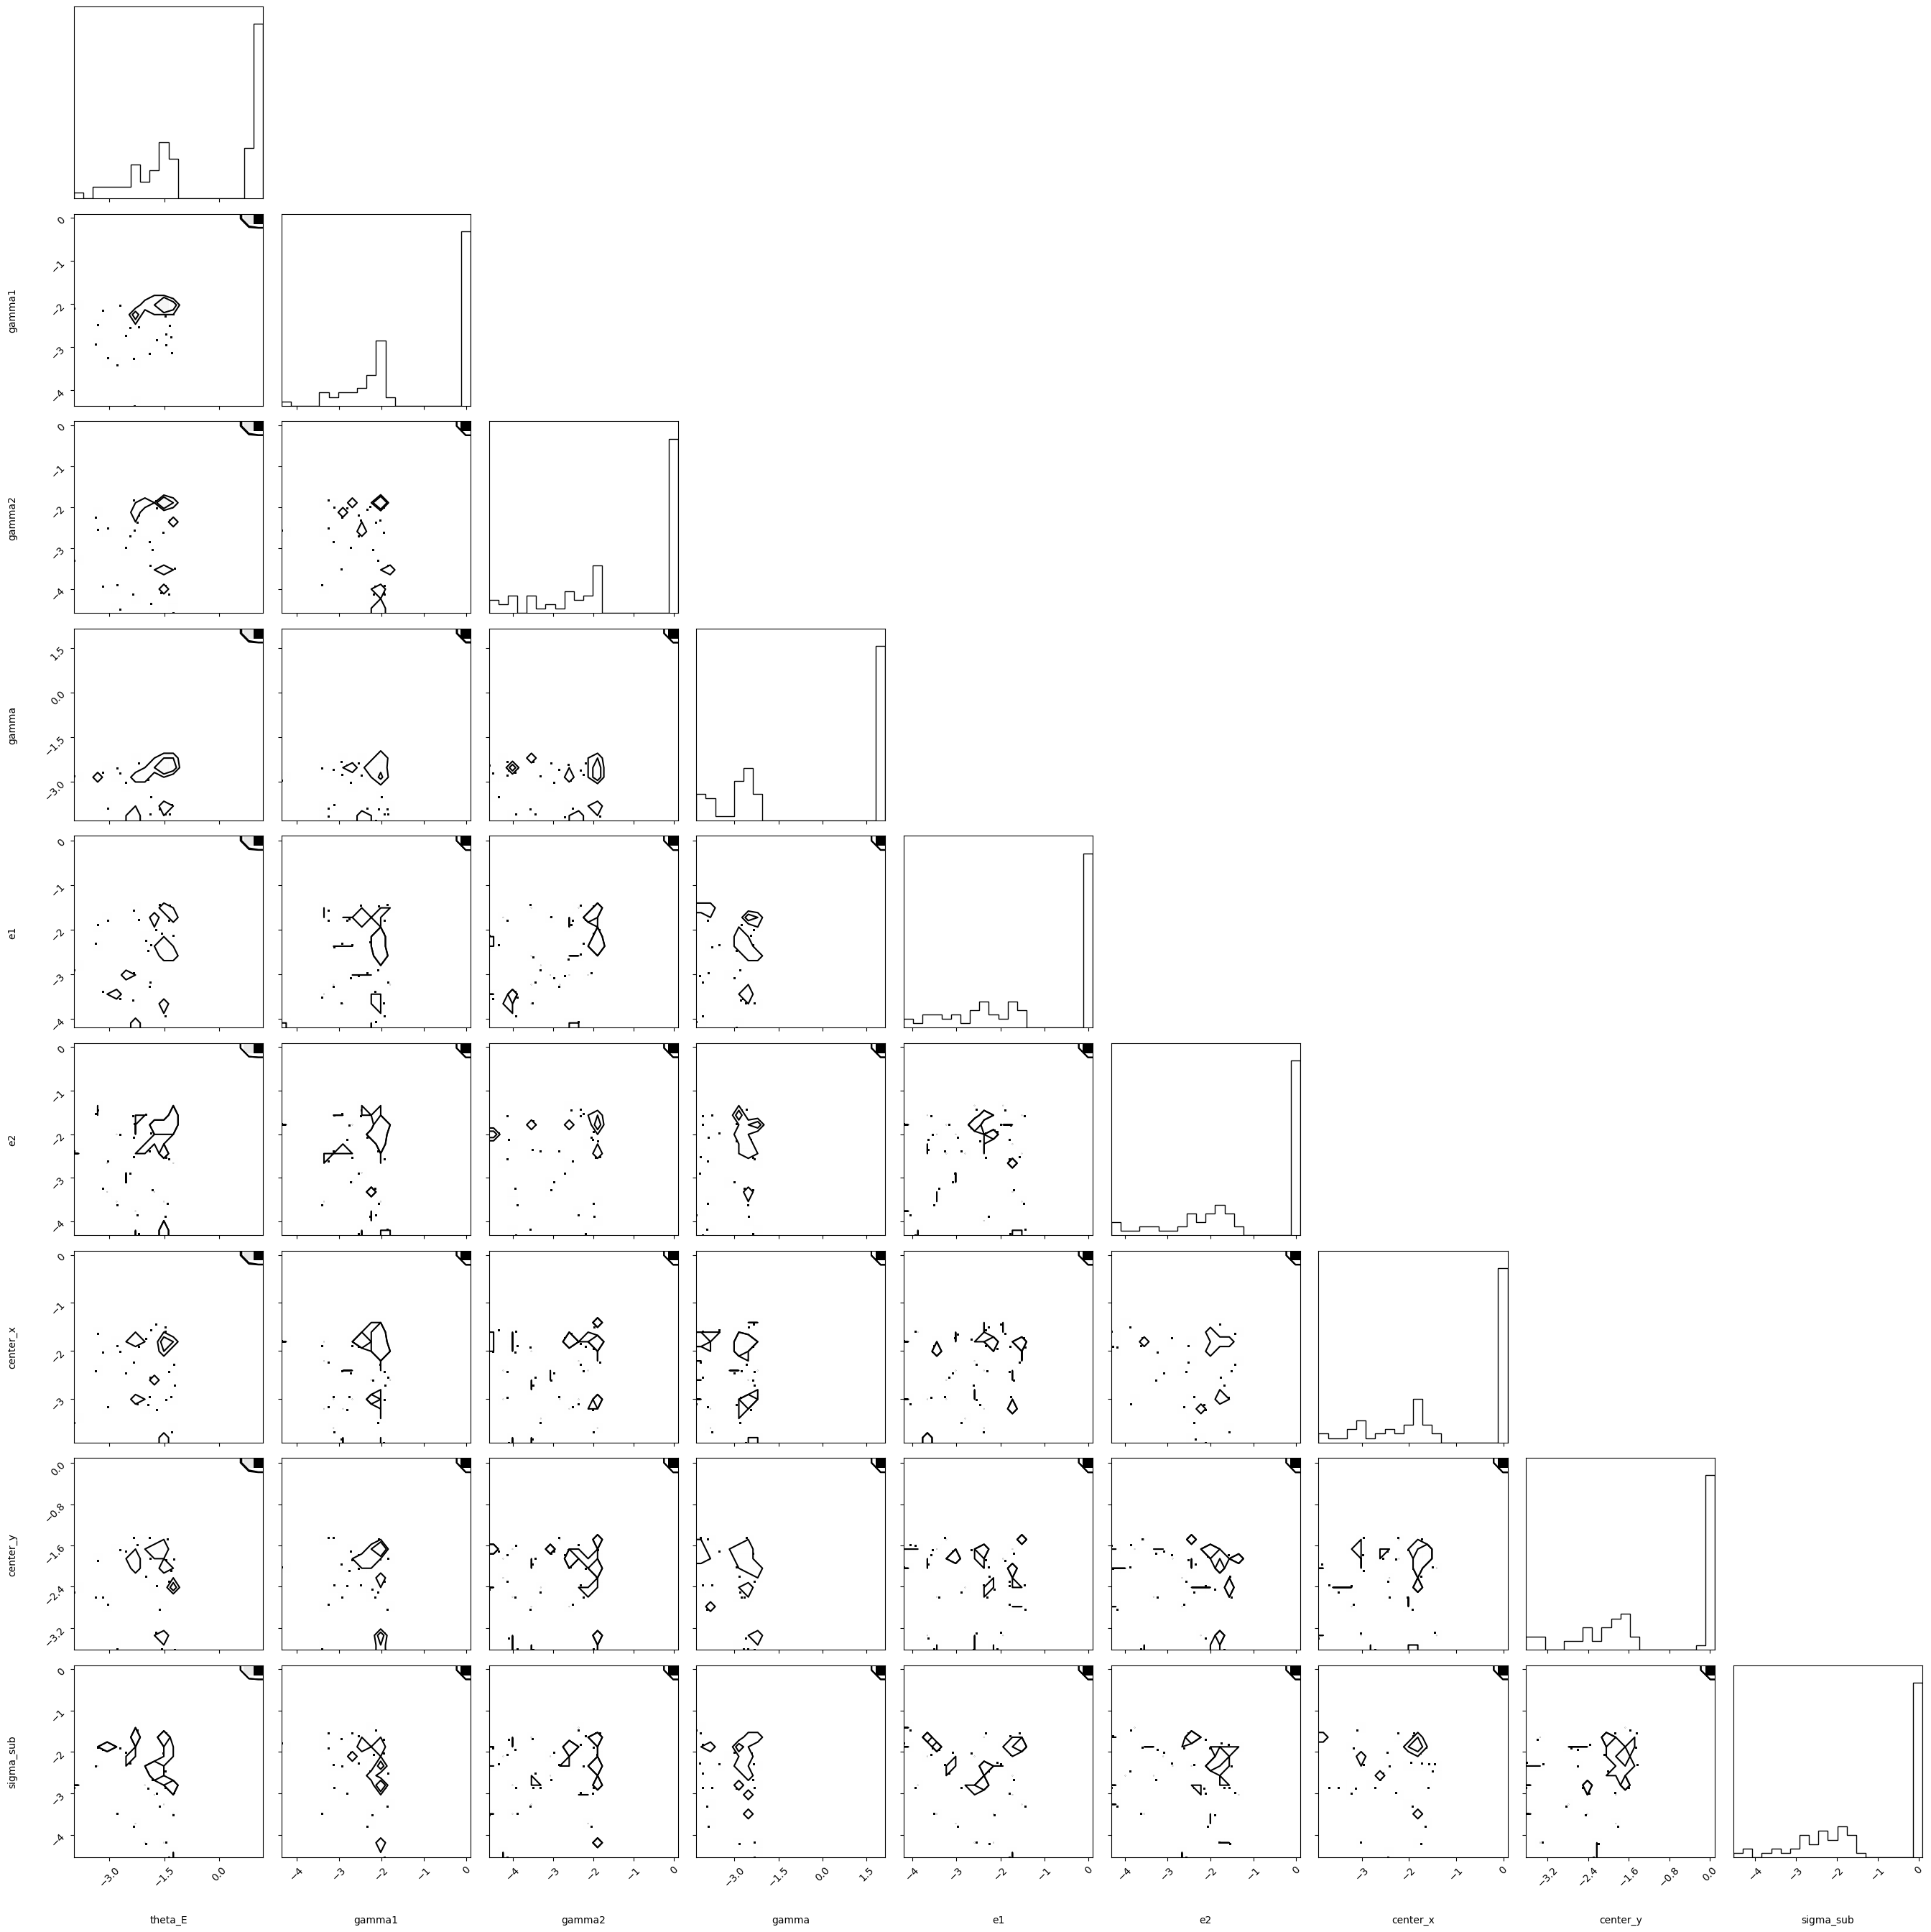

In [26]:
corner_param_print=[r'$\Sigma_\mathrm{sub,pop} \times 10^{3}$' + '\n' + r'$[\mathrm{kpc}^{-2}]$',
                    r'$\log \Sigma_\mathrm{sub,pop,\sigma} \times 10^{3}$' + '\n' + r'$[\mathrm{kpc}^{-2}]$']

corner_param_print= [elem.replace('main_deflector_parameters_','').replace('subhalo_parameters_','') for elem in learning_params]
print(len(corner_param_print))
fontsize = 20
color='#FFAA00'
truth_color = 'k'
hist_kwargs = {'density':True,'color':color,'lw':3}
fig = plt.figure(figsize=(3*len(learning_params),3*len(learning_params)))
corner.corner(chain,labels=corner_param_print,fig=fig)#,bins=20,show_titles=False,plot_datapoints=False,label_kwargs=dict(fontsize=fontsize),
            #  levels=[0.68,0.95],color=color,fill_contours=True,hist_kwargs=hist_kwargs,title_fmt='.2f',truths=true_hyperparameters,
             # truth_color=truth_color,max_n_ticks=3,fig=fig)

plt.tight_layout()
for format_i in ['png','pdf']:plt.savefig(paltas_directory+'/paltas/summary_plots/example_corner_plot.'+format_i)
plt.show()